## Objective
___


We are placing ourselves in the position of the owners of a movie streaming platform, akin to Netflix, Hulu, Showtime and the like.

We are going to **recommend movies to users this streaming platform** that have already rated at least one movie.

Our full dataset can be found here: [Full Movielens Dataset](https://grouplens.org/datasets/movielens/ )

We wish to focus on a particular business objective : **recommend movies to users that are already watching at least a few movies on the platform**. Those users can be seen as valuable customers that are more likely to keep watching movies, especially if recommendations are relevant and, more importantly, are perceived as relevant by the user. Therefore we feel it is important to keep those users' business and enhance their experience with great recommendation to keep their interest up.

To gain practical intuition for how some models work, and to develop methods to test and explore them, we will greatly **reduce the original data** (~ 27 M ratings) to  ~ 1 M ratings (10,000 users and 1,000 movies). 

#### Which ratings are we keeping?

To obtain this new small dataset we are first going to **sample 1,000 movies** from the full dataset. The following discussion considers this new dataset with only 1,000 items.

we are going to **sample users those users that have rated at least $user\_min\_ratings$ movies**. We will keep $user\_min\_ratings$ small enough so that our matrix is not too dense - with the risk of over-simplifying - but large enough so that it aligns with our formulated business problem. We expect to choose $user\_min\_ratings$ after exploring our data and looking at the distribution of number of ratings per user and per item.

We are guaranteed to obtain users that each have at least $user\_min\_ratings$ ratings; a setting already **favorable to user-based collaborative filtering**.

Once we have filtered out the dataset, we simply sample 10,000 users and 1,000 items from the resulting dataset at random.

#### What recommendation engines do we implement? 

We chose to implement one model-based recommendation algorithm (**Matrix Factorization with L2 regularization**) and one neighborhood-based collaborative filtering algorithm (**user-based**), as well as a baseline algorithm (**user and item mean rating**) for comparison.

#### What are we trying to optimize? What are we willing to sacrifice?

We will focus on **accuracy** metrics for this preliminary project. Many secondary goals such as novelty, trust, coverage and serendipidity are important to the user experience. These metrics have important short-term and long-term impacts on the conversion rates but there are often no hard measures to provide a numerical metric to measure those so we may want to examine them in our more complex recommender system rather than in this first one.

One idea is to use the MSE or **RMSE** to measure accuracy. They are common metrics used in literature to compare recommender systems offline. The RMSE is in units of ratings rather than in unites of squared ratings like the MSE - which makes it more interpretable than the MSE. The RMSE tends to disproportionately penalize large errors because of the squared term within the summation. It also aligns nicely with the evaluation of matrix factorization which essentially attempts to reduce the MSE of the ratings matrix and the generated latent factor matrices. This will be our primary accuracy metric.

A more natural way to evaluate our recommendations is to use ranking-based metric. We will dive into this deeper as we test our recommendation system, and point out why we think precision is more important than recall in our case. We will use the **Kendall rank correlation coefficient** as a secondary accuracy metric to evaluate our system.

We will also implement a measure of **coverage** to see how the movie catalog is exploited by the algorithms.

#### How to decide which algorithm to deploy?

We will compare the accuracy metrics and coverage across the three algorithms (matrix factorization, user-based collaborative filtering and baseline). We will only consider picking an algorithm amongst the two non-baseline if it performs significantly better than the baseline in terms of accuracy (RMSE and Kendall rank). 

If they both have much better accuracy than the baseline we will then compare them. We will look at both coverage and accuracy to choose one of them. A significantly higher accuracy of one over the other will weight heavy in the decision making process although very poor coverage compared to the other one might also be a great concern and change our decision.

We do not supply hard numbers and thresholds in terms of accuracy or coverage that need to be reached as we understand that the metrics magnitude will heavily depend on the data at hand. We will prefer comparisons with the baseline to make a decision.


## Table of contents
___

1. [Preparing the data for recommendation](#1)
2. [Exploring the small dataset](#2)
3. [Splitting the data into train and test sets](#3)
4. [Cross-validation : training and tuning](#4)
    1. [Algorithm 1 - Matrix Factorization with L2 regularization](#5)
        1. [Implementation of the model](#6)
        2. [Tuning the hyper-parameters](#7)
        3. [Changing model size](#8)
    2. [Algorithm 2 - User-based neighborhood model](#9)
        1. [Implementation of the model](#10)
        2. [Tuning the hyper-parameters](#11)
        3. [Changing model size](#12)
5. [Evaluation of the models](#13)
6. [Final decision](#14)

<a id='1'></a>
### Preparing the data for recommendation
___

See **`Preparing the dataset.html`** for a detailed explanation of how we generated the small dataset. 

See **`Preparing the dataset.ipynb`** for reproduction of the code.

<a id='2'></a>
### Exploring the small dataset
___

Let us now reconduct the exploration phase on this small dataset, to see if there any notable differences with the original dataset and anticipate the behavior of the recommendation pipeline to characteristics of the data.

First we load the dataset we saved under `ratings_small.csv`:

In [1]:
import pandas as pd
import numpy as np
from lib import utils
from lib import preprocessing as prepro

In [2]:
ratings = pd.read_csv('ratings_small.csv')
ratings.head()

,user,item,rating
0,18,6,3.0
1,18,21,3.0
2,18,161,4.0
3,18,216,3.0
4,18,230,4.0


In [3]:
total_ratings = utils.total_ratings(ratings)
total_ratings

89099

We ended end with near 80,000 ratings, down from 27 M ratings - a drastic reduction.

In [4]:
total_users = utils.unique_users(ratings)
total_users

10000

In [5]:
total_items = utils.unique_movies(ratings)
total_items

879

In [6]:
ratio = utils.shape_matrix_index(ratings)
ratio

0.0879

In [7]:
sparsity = utils.sparsity_index(ratings)
sparsity

0.9898635949943118

The resulting matrix is still sparse although less than the original data.

<a id='3'></a>
### Generating train and test sets
___

We are going to implement two basic recommendation algorithms:
- user-based neighborhood model
- non-negative matrix factorization

We will use the `scikit-learn` package to wrap our algorithms.

Let us first divide our data into training and testing sets. We implement an approximate `85 / 15` split - which might seem to keep too much training data; however in absolute terms, the little data we have should not lead to overfitting easily - in an effort to train on as much data as possible and still be able to evaluate the performance of our algorithms on enough data. We will use cross-validation to tune our algorithms so each part of the training set will be used as a validation set at some point.


First we have to make sure that we have **at least one rating for each item and one rating for each user in the training set**. This is important to be able to recommend movies to all users (and not miss movies that are might turn out to be highly recommended for some users), though those users and items will not appear in the testing set. This means they won't contribute to the evaluation of our recommendation systems and that might be a problem if there are too many of those, as it would reduce the already small dataset on which we can evaluate our algorithms. 



First we hash the data so that we now have items and users numbered from 1 to the number of unique items / users - the original ids will be kept in columns `old_user` and `old_item` to reverse engineer when needed:

In [8]:
hashed_ratings = utils.hash_data(ratings)

Then we put all ratings of items that have just one rating in the training set and return a ratings matrix without them:

In [9]:
t, reduced_ratings = prepro.separate_items_with_few_ratings(1, hashed_ratings)

The relative size of those ratings is:

In [10]:
t.size / total_ratings

0.014534394325413305

We have approximately 0.15 % of the data in the training set for now. This portion is small enough to not be alarmed: the portion of data that will not contribute to the evaluation of our systems is very small. 

Let us now generate training and testing sets from the data with those ratings removed with stratification on items:

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test,_,_ = train_test_split(reduced_ratings, 
                                       reduced_ratings['item'], 
                                       test_size = 0.15, 
                                       stratify = reduced_ratings['item'],
                                       random_state = 596)


Now we can concatenate `t` and `X_train` to obtain the full training set.

Its relative size is:

In [13]:
X_train = pd.concat([t, X_train])
X_train.size / (X_train.size + X_test.size)

0.8504360318297624

which is close to the train/test ratio we wanted (`85/15`). Let us check that we have all items and users in the training set:

In [14]:
total_items - X_train['item'].unique().size

0

We have all items

In [15]:
reduced_ratings['user'].unique().size - X_train['user'].unique().size

1

We are missing one user in the train set. Let us manually fetch her:

In [16]:
X_test[-X_test['user'].isin(X_train['user'].unique())]

,old_user,old_item,user,item,rating
2212,7026,590,255,25,4.0
2213,7026,592,255,26,3.0
2211,7026,161,255,7,5.0


Now, we add one of her ratings to the training set and remove it from the testing set:

In [17]:
X_train = pd.concat([pd.DataFrame({'old_user' : [7026], 'old_item' : [590],
                                   'user': [255], 'item' : [25], 
                                   'rating' : [4.0]}), X_train], 
                    ignore_index = True)
X_test = X_test[-(np.logical_and(X_test['user'] == 255, X_test['item'] == 25))]

We now have **all users and all items in the training set**.

Before moving on to the algorithms, let us place the ratings in `y` pandas Series:

In [18]:
y_train = X_train['rating']
y_test = X_test['rating']
X_train = X_train.drop('rating', axis = 1)
X_test = X_test.drop('rating', axis = 1)

<a id='4'></a>
## Cross-validation : training and tuning
___

<a id='5'></a>
### Algorithm 1 - Matrix Factorization with L2 regularization
___

<a id='6'></a>
#### Implementation of the model

We implemented **matrix factorization with L2 regularization**. 
The code can be found in `/lib/MF.py`

We wanted to keep the recommendation algorithm simple for this part of the project and adding regularization to reduce proneness to overfitting did not complicate the implementation nor is it a conceptual stretch. 
It did add an **extra parameter** to tune.

Let us first import the tools we need:
- `skleran.base.BaseEstimator` is a scikit-learn interface that estimators need to implement so that we can use other tools supplied by the scikit-learn package
- `sklearn.base.RegressorMixin` is an abstract class for regression estimators
- `sklearn.model_selection.GridSearchCV` will allow us to use the grid search already implemented with cross-validation to find a nice starting point for our parameters before studying their influence on the score and fine-tuning the algorithm

In [19]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import GridSearchCV

One thing to note is that we chose to implement *L2 regularization with a shared parameter between user and item factors*. This choice was motivated by the will to keep the algorithm simple but also and mostly because with the limited data we felt having two differents parameters might overcomplicate the model without the data to back it up and find values for the two parameters that generalize well.

An implementation hurdle was coping with the fact that the validation phase requires further partitioning the training set. That partition then removes some users and items from the training phase. We had to make up for this by flagging items and users that were examined and used in the training phase, and only computing the validation score on entries for those items and users.

In [20]:
from lib import MF

We then tried to run a grid search with cross-validation (similar split train/validation ratio than the train+validation/test ratio):

In [21]:
parameter_grid = {"n_epochs" : range(10, 101, 20), 
                "n_factors" : range(10, 71, 20),
                "learning_rate" : [0.001, 0.003, 0.005, 0.01],
                "learning_rate_bias" : [0.003, 0.005, 0.007, 0.01],
                "lambd" : [0.01, 0.03, 0.05, 0.1]}

model1 = MF.MF(unique_users = total_users, unique_items = total_items, verbose = True)
gs = GridSearchCV(model1, parameter_grid, cv = 5, error_score = 'raise')

In [22]:
#gs.fit(X_train, y_train.values)

We found the Grid Search to be excruciatingly long for such a small dataset. Looking to optimize the code, we decide to go in the way of **cythonization to aggressively optimize the fitting procedure**.
The full code with cython can also be found in `/lib/MF_cython.pyx`

In [23]:
%load_ext Cython

In [24]:
%%cython

from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
from six.moves import range

cimport cython

import numpy as np
cimport numpy as np 

from sklearn.base import BaseEstimator, RegressorMixin

from lib import utils

class MF_cython(BaseEstimator, RegressorMixin):  
     
    def __init__(self, n_epochs = 20, n_factors = 20, 
                 learning_rate = .007, learning_rate_bias = .007,
                 lambd = 0.02,
                 unique_users = 0, unique_items = 0,
                 verbose = False,
                 random_state = None,
                 response_vector = None):
        """
        This method is called when initializing the estimator
        and assigns values to the object's parameters
        The default values where chosen to be the same
        as the SVD in the scikit `surprise` package 
        Args:
            - self: MF object, to be initialized
            - n_epochs: int, the number of epochs
            - n_factors: int, the number of factors in the
            latent user and item matrices
            - learning_rate: float, the learning rate for the
            SGD procedure used to find the user and item matrices
            - learning_rate_bias: float, the learning rate for the
            SGD procedure for the user and item biases
            - lambd: float, the L2 regularization parameter
            chosen to be the same for user and item vectors
            - unique_users: int, the number of unique users
            - unique_items: int, the number of unique items
            - verbose: boolean, if True prints the progress of 
            the fit procedure for training purposes
            - response_vector: array, used by the GridSearchCV class
            of scikit-learn, kept equal to None in our work
        """
        self.n_epochs = n_epochs
        self.n_factors = n_factors
        self.verbose = verbose
        self.learning_rate = learning_rate
        self.learning_rate_bias = learning_rate_bias
        self.lambd = lambd
        self.response_vector = response_vector
        self.unique_users = unique_users
        self.unique_items = unique_items
    
    @cython.boundscheck(False) # turn off bounds-checking for function
    @cython.wraparound(False) # turn off negative index wrapping for function
    def fit(self, X, y):
        """
        This methods fits the algorithm to the data
        Args:
            - self: MF object, to be fitted
            - X: panda DataFrame, with hashed available pairs of item-user
            in columns `user` and `item`
            - y: panda Series, with corresponding ratings to the
            pairs of item-user in X
        """
        
        # Declarations
        
        # User and Item latent factors matrices
        cdef np.ndarray[np.double_t, ndim = 2] U
        cdef np.ndarray[np.double_t, ndim = 2] V
        
        # Bias vectors
        cdef np.ndarray[np.double_t] Bu
        cdef np.ndarray[np.double_t] Bi
        
        # Error vector
        cdef np.ndarray[np.double_t] err
        
        # Numpyp array versions of columns in X
        cdef np.ndarray[np.int16_t] user_column
        cdef np.ndarray[np.int16_t] item_column
        
        # Numpy array that will control the order of the updates
        cdef np.ndarray[np.long_t] random_indices
        
        # Visited users and items
        cdef np.ndarray[np.int8_t] known_u
        cdef np.ndarray[np.int8_t] known_i
        
        cdef int f, index
        cdef double dot, Uf, Vf
        cdef int nb_users, nb_items, size
        cdef double global_mean
        
        # aliases
        cdef double lr = self.learning_rate
        cdef double lrb = self.learning_rate_bias
        cdef double l = self.lambd

        # Initializations
        nb_users = self.unique_users
        nb_items = self.unique_items
        size = utils.total_ratings(X)
        
        Bu = np.zeros(nb_users, np.double)
        Bi = np.zeros(nb_items, np.double)
        
        U = np.random.rand(nb_users, self.n_factors)
        V = np.random.rand(nb_users, self.n_factors)
        
        user_column = np.array(X['user'], np.int16)
        item_column = np.array(X['item'], np.int16)
        
        err = np.zeros(size, np.double)
        
        known_u = np.zeros(nb_users, np.int8)
        known_i = np.zeros(nb_items, np.int8)
        
        global_mean = np.mean(y)

        # Run SGD to update the factors
        for epoch in range(self.n_epochs):
            
            if self.verbose and (epoch == 0 or (epoch + 1) % 10 == 0):
                print("Starting epoch {}".format(epoch + 1))
            
            random_indices = np.random.permutation(size)
            
            for index in random_indices:
                
                # -1 because hashing created users and items with integer
                # values starting at 1
                user = user_column[index] - 1
                item = item_column[index] - 1
                
                # mark user and item as visited
                known_u[user] = 1
                known_i[item] = 1
                
                dot = 0
                for f in range(self.n_factors):
                    dot += V[item, f] * U[user, f] 
                    
                # update error
                err[index] = y[index] - (global_mean + Bu[user] + Bi[item] + dot)
                
                # update biases
                Bu[user] += lrb * err[index]
                Bi[item] += lrb * err[index]
                
                # simultaneous update
                for f in range(self.n_factors):
                    Uf = U[user, f]
                    Vf = V[item, f]
                    U[user, f] += lr * (err[index] * Vf - l * Uf)
                    V[item, f] += lr * (err[index] * Uf - l * Vf)
           
        # store the results
        self.bias_user_ = Bu
        self.bias_item_ = Bi
        self.latent_users_ = U
        self.latent_items_ = V
        
        # store training mean
        self.global_mean_ = global_mean
        
        # store visited items and users
        self.known_users_ = known_u
        self.known_items_ = known_i
        
        # compute the score: -RMSE
        self.score_ = - np.sqrt(np.sum(err**2) / size)
        
        return self
    
    
    def predict(self, X, y = None):
        """
        This function predicts the ratings for the data in X
        if the algorithm has been fitted, and throws an error otherwise
        Args:
            - self: MF object, should have called fit method earlier
            - X: panda DataFrame, with pairs of item-user without ratings
            - y: panda Series, needs to be supplied to insert in scikit-learn
            pipeline but kept to value `None`
        Output:
            - prediction: np array, containing the predicted ratings for
            each user-item pair in X
        """
        
        try:
            getattr(self, "latent_users_")
        except AttributeError:
            raise RuntimeError("You must fit the model before predicting.")
        
        # initialize predictions
        prediction = np.zeros(X['user'].size)
        
        for index in range(X['user'].size):

            user = utils.get_user_at(index, X) - 1
            item = utils.get_item_at(index, X) - 1

            if(self.known_users_[user] == 1 and self.known_items_[item] == 1):
                dot = np.dot(self.latent_items_[item,], 
                             self.latent_users_[user,]) 
                bias = self.bias_user_[user] + self.bias_item_[item]
                prediction[index] = dot + self.global_mean_ + bias
            else:
                prediction[index] = float('NaN')
        
        return prediction

    
    def score(self, X, y):
        """
        This function returns the score obtained at the end of training
        Args:
            - self: MF object, should have called fit method earlier
            - X: panda DataFrame, with pairs of item-user with ratings
            - y: panda Series, contains the ratings associated with pairs in X
        Output:
            - score: float, the score on the training data (- RMSE)
        """
        size = utils.total_ratings(X)
        prediction = self.predict(X)
        err = 0
        real_size = 0
        for i in range(size):
            if(prediction[i] == prediction[i]): # check if NaN
                err += (prediction[i] - y[i])**2
                real_size += 1
        score = - np.sqrt(err / real_size)
        return score

We reran a grid search with this cythonized version of matrix factorization which ran much quicker on our machines:

In [25]:
model2 = MF_cython(unique_users = total_users, unique_items = total_items, verbose = True)
gs = GridSearchCV(model2, parameter_grid, cv = 5, error_score = 'raise')

In [26]:
#gs.fit(X_train, y_train.values)
#print(gs.best_params)

*(comment out if you want to run the grid search, it might take a while as it runs more than 50,000 epochs!)*

From this search and a we obtained best parameters :
- `n_epochs`: 50
- `n_factors`: 30
- `learning_rate`: 0.005
- `learning_rate_bias`: 0.007
- `lambd`: 0.03


We will use these values as the starting point for further manual fine-tuning:

In [27]:
parameters = {'n_epochs' : 50 , 'n_factors' : 30 , 'learning_rate' : 0.005, 'learning_rate_bias' : 0.007,
              'lambd' : 0.03, 'unique_users' : total_users, 'unique_items' : total_items}

<a id='7'></a>
#### Tuning the hyper-parameters

In [28]:
import matplotlib.pyplot as plt

Starting with the parameters obtained with grid search let us study the influence of each parameter, maintaining the others fixed. For each parameter we will **plot the RMSE of the validation data obtained with cross-validation**.

We will go through a few rounds of tuning, stopping when the gains in RMSE across the considered values are judged too small to reveal a better model rather than just fit this particular training data better. We will consider that we need an improvement of at least `0.001` in the RMSE to continue tuning a parameter.

In [29]:
from sklearn.model_selection import cross_val_score

In [30]:
def compute_rmse(parameter_name, parameter_list, parameters):
    rmse_validation = []
    for parameter_value in parameter_list:
        parameters[parameter_name] = parameter_value
        model = MF_cython(**parameters)
        scores = cross_val_score(model, X_train, y_train.values, cv = 5)
        rmse_validation.append(-np.average(scores))
    return rmse_validation

#### 1. First round of tuning

- `n_epochs`

In [31]:
epochs = [1, 5, 10, 20, 30, 40, 50, 60, 70, 80]
rmse_validation = compute_rmse('n_epochs', epochs, parameters)

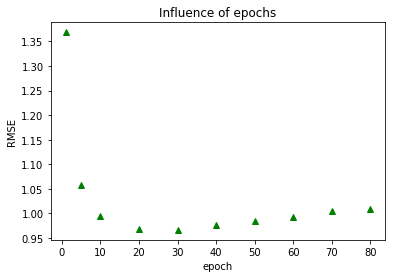

In [32]:
utils.plot_rmse('epoch', epochs, rmse_validation)

From this plot we see that starting around `epoch 20`, there seems to be overfitting on the training data, detrimental to generalization on the validation data. A global minimum of RMSE due to epoch change seems to lie around epoch 20 and we will see if we can get significantly improve the RMSE in a second round of tuning after tuning the other parameters.

In [31]:
parameters['n_epochs'] = 20

- `n_factors`

In [34]:
factors = [10, 20, 30, 40, 50, 60, 70, 80]
rmse_validation = compute_rmse('n_factors', factors, parameters)

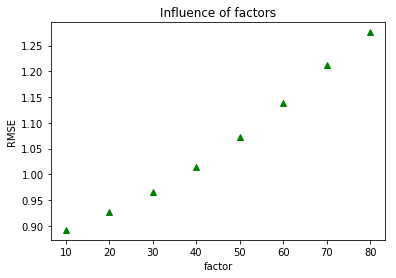

In [35]:
utils.plot_rmse('factor', factors, rmse_validation)

The plot tells us that the optimal number of factors is probably near the lowest values we tried (at least for the values of the other fixed parameters). We were surprised to see that so few dimensions provided better result. Again, with the little data at hand, fitting a complex model does not make much sense and is bound to give worse results that a simpler one if the data is not sufficient to properly tune the coefficients in the matrices.

We will look into finding a better value in a second round.

In [32]:
parameters['n_factors'] = 10

- `learning_rate`

In [37]:
lrs = [0.001, 0.003, 0.005, 0.007, 0.01, 0.03, 0.05, 0.07]
rmse_validation = compute_rmse('learning_rate', lrs, parameters)

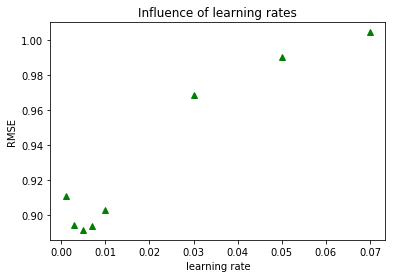

In [38]:
utils.plot_rmse('learning rate', lrs, rmse_validation)

The optimal learning rates so far seem to lie between 0.001 and 0.01, which is a typical range for a learning rate for a stochastic gradient descent problem. A learning rate that is too large has greater chances of missing local optima and rather dance around it and skipping critical regions because the updates are too large. On the other hand, a learning rate that is too small requires much more convergence time and we might not reach local minimas with the current number of epochs.

For now we will pick one of the two values that gave the lowest RMSE.

In [33]:
parameters['learning_rate'] = 0.005

- `learning_rate_bias`:

In [40]:
rmse_validation = compute_rmse('learning_rate_bias', lrs, parameters)

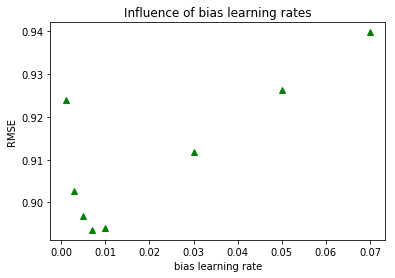

In [41]:
utils.plot_rmse('bias learning rate', lrs, rmse_validation)

The learning rate for bias (shared between user and item biases) seems to give better results between 0.005 and 0.01 - for the fixed values of the other parameters we have.

In [34]:
parameters['learning_rate_bias'] = 0.007

- `lambd`

In [43]:
lambdas = [0.01, 0.03, 0.05, 0.07, 0.1, 0.3, 0.5, 0.7]
rmse_validation = compute_rmse('lambd', lambdas, parameters)

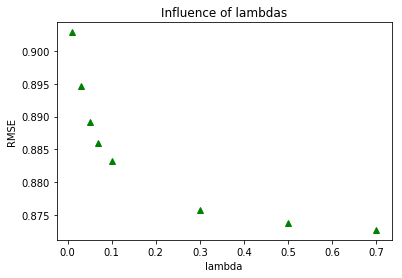

In [44]:
utils.plot_rmse('lambda', lambdas, rmse_validation)

The optimal regularization parameters so far seem to lie between 0.5 and 0.7, which is outside of a typical range for a L2 regularization parameter for a stochastic gradient descent linear problem. Too high a lambda prevents the algorithm from learning useful features and fitting the data. Too low a value prevents the algorithm from reaping the benefit of regularization, which is to control the size of the parameters learned to reduce risks of overfitting.

Having a high lambda reduces the weight of the latent factors in the prediction and gives more importance to the bias terms.

The baseline algorithm we will compare this too is pure biases and will probably perform well on the data, since the training here demonstrates that the biases should be heavily weighted compared to the factor dot product.

We will pick the following value of lambda moving on:

In [35]:
parameters['lambd'] = 0.7

#### 2. Second round of tuning

- `n_epochs`

In [46]:
epochs = [15, 20, 25]
rmse_validation = compute_rmse('n_epochs', epochs, parameters)

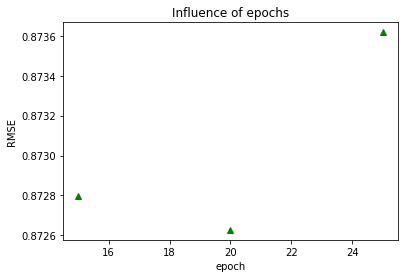

In [47]:
utils.plot_rmse('epoch', epochs, rmse_validation)

Looking at the plot we decide to stick with the previous value of `20` for `n_epochs`. 

It does not make much sense to continue tuning the epoch number further, it would most probably not generalize so well if discretize the field of possible values further.

- `n_factors`

In [48]:
factors = [7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
rmse_validation = compute_rmse('n_factors', factors, parameters)

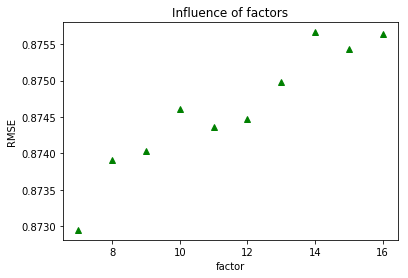

In [49]:
utils.plot_rmse('factor', factors, rmse_validation)

We can improve the RMSE with `n_factors = 7` compared to the previous 10. We fear taking such a low value will lead to poor generalization so we will stick with 10.

We end up with a - still - very low value for the number of factors (10) which can be surprising. Nevertheless we believe the size of the data explains that a model with so few degrees of freedom (taking each cell in the item and user matrices as a degree of freedom) can explain the patterns in the ratings pretty well. 

With 10 factors, we reduce the maximum number of cells from the original matrix `nb_items * nb_users = 10M` to `n_factors * (nb_items + nb_users) = 110,000` approximately, which is a reduction of parameters to estimate of one hundreth!

- `learning_rate`

In [50]:
lrs = [0.006, 0.007, 0.008, 0.009]
rmse_validation = compute_rmse('learning_rate', lrs, parameters)

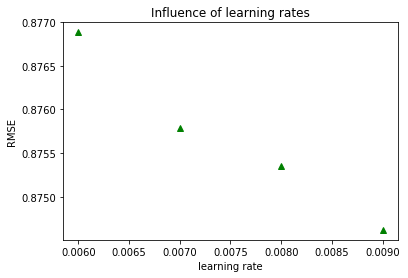

In [51]:
utils.plot_rmse('learning rate', lrs, rmse_validation)

The gain in RMSE for any of the values is larger than 0.001 compared to its value for `learning_rate = 0.007` and remains in a reasonable range for a learning rate - giving us confidence that we might not be overly overfitting the training data - so we will change to 0.009.

In [36]:
parameters['learning_rate'] = 0.009

- `learning_rate_bias`

In [52]:
lrs = [0.008, 0.009, 0.01]
rmse_validation = compute_rmse('learning_rate_bias', lrs, parameters)

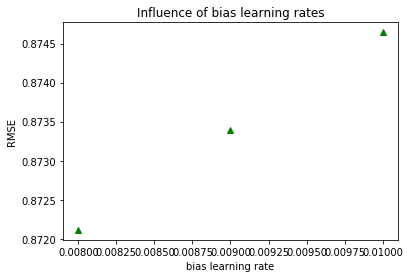

In [53]:
utils.plot_rmse('bias learning rate', lrs, rmse_validation)

We pick value 0.008 for `learning_rate_bias` with a gain in more than 0.002 in RMSE, keeping in a reasonable range for a learning bias.

In [37]:
parameters['learning_rate_bias'] = 0.008

- `lambd`

In [55]:
lambdas = [0.6, 0.7, 0.8, 0.9, 1.]
rmse_validation = compute_rmse('lambd', lambdas, parameters)

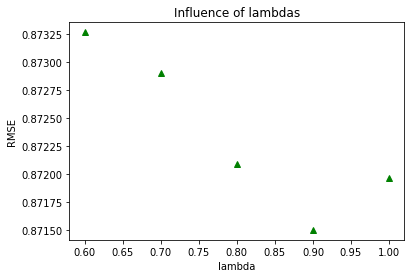

In [56]:
utils.plot_rmse('lambda', lambdas, rmse_validation)

We will set `lambda` to 0.9 and will stop the tuning here. This is a very high regularization parameter which gives a lot of importance to the user and item biases. We will see how it compares to the baseline with only biases.

In [38]:
parameters['lambda'] = 0.9

*In a business setting, with more computational power, we would distribute this tuning procedure with many different starting points - rather than just the one obtained with a single grid search - to find a better local optimum. We realize the parameters we chose have little chance of representing the best model out of all possible models we could try. Nevertheless, it might be a good enough model with regards to the acceptance criteria described in our introduction with comparisons with a baseline.*

Summarizing our model :

In [31]:
parameters = {'n_epochs' : 20 , 'n_factors' : 10 , 'learning_rate' : 0.009, 'learning_rate_bias' : 0.008,
              'lambd' : 0.9, 'unique_users' : total_users, 'unique_items' : total_items}
mf_model = MF_cython(**parameters) 

Let us fit our model to prepare it for evaluation:

In [32]:
mf_model.fit(X_train, y_train.values)

MF_cython(lambd=0.9, learning_rate=0.009, learning_rate_bias=0.008,
     n_epochs=20, n_factors=10, random_state=None, response_vector=None,
     unique_items=879, unique_users=10000, verbose=False)

<a id='8'></a>
#### Changing model size

Let us now go back and subsample the original data, to study the impact of a change in model size both in terms of accuracy and runtime:

In [58]:
import time

In [ ]:
scores = []
times = []
sample_sizes = np.linspace(0.1*total_ratings, total_ratings, 10)
for size in sample_sizes:
    subsample_ratings = ratings.sample(int(size))
    hashed_ratings_sub = utils.hash_data(subsample_ratings)
    t_sub, reduced_ratings_sub = separate_items_with_few_ratings(1, hashed_ratings_sub)
    X_train_sub, X_test_sub,_,_ = train_test_split(reduced_ratings_sub, 
                                           reduced_ratings_sub['item'], 
                                           test_size = 0.15, 
                                           stratify = reduced_ratings_sub['item'],
                                           random_state = 769)
    X_train_sub = pd.concat([X_train_sub,t_sub])
    y_train_sub = X_train_sub['rating']
    y_test_sub = X_test_sub['rating']
    mf = MF_cython(**parameters)
    start = time.time()
    mf.fit(X_train_sub, y_train_sub.values)
    end = time.time()
    times.append(end - start)
    scores.append(-mf.score(X_test_sub, y_test_sub.values))


In [62]:
sample_sizes = [x / 1000 for x in sample_sizes]

Let us plot the scores :

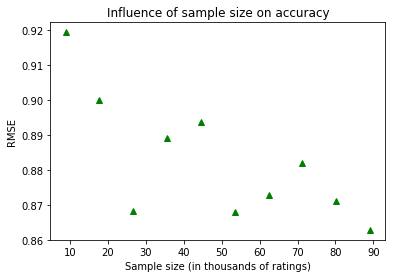

In [63]:
plt.plot(sample_sizes, scores, 'g^')
plt.xlabel('Sample size (in thousands of ratings)')
plt.ylabel('RMSE')
plt.title('Influence of sample size on accuracy')
plt.show()

The overall trend is a small decrease in RMSE from 0.90 to under 0.865. 


Now, let us plot the runtime :

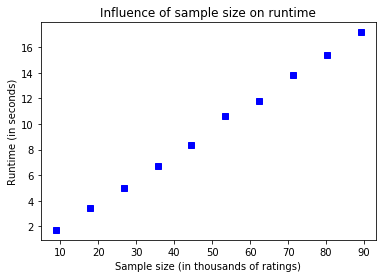

In [64]:
plt.plot(sample_sizes, times, 'bs')
plt.xlabel('Sample size (in thousands of ratings)')
plt.ylabel('Runtime (in seconds)')
plt.title('Influence of sample size on runtime')
plt.show()

As expected, with a fixed number of factors, the time complexity is linear in the number of ratings used for training! This can be leveraged to scale if more data is available, this algorithm shouldn't give us problems to train and tune, especially if we distribute the calculations for grid search and cross validation to tune parameters. Space complexity is an entirely different issue that hasn't been handled here at all nevertheless.

<a id='9'></a>
### Algorithm 2 - User-based neighborhood model

We implemented **k-nearest neighbors** user_based collaborative filtering from scratch. The code can be found in `./lib/knn.py`.

We chose to use the `surprise` package in our analysis here to familiarize ourselves with this framework - which has a similar implementation to ours but is more optimized. 

We import the following:
- `surprise.prediction_algorithms.knns` contains prediction algorithms that are directly derived from a basic nearest neighbors approach.
- `surprise.Dataset` handles dataset creations to prepare them for prediction
- `surprise.Reader` handles the loading of a dataset from a Pandas dataframe
- `surprise.model_selection.KFold` allows us to cross-validate to tune the number of neighbors
- `surprise.accuracy` contains the RMSE metric used to evaluate the algorithm

In [33]:
from surprise.prediction_algorithms import knns
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import KFold
from surprise import accuracy

<a id='10'></a>
#### Implementation of the model

To load the model we just use this simple call - the number of neighbors is implicitely set to `40` as a starting point.

In [34]:
nm = knns.KNNBasic(sim_options = {'name' : 'pearson'}, verbose = False)

*Why did we turn to the Pearson similarity measure rather any other such as cosine?*

The Pearson coefficient is invariant to shifts in the input which makes it more robust, a quality we look fort in order to be able to scale and bring in more data at some point.
The Pearson measure tends to eliminate the offsets in rating patterns between users, leaving only the comparative differences across items; as such it is generally desirable.
Choosing another metric would require more justification based on data exploration, so our safest bet is Pearson for now.

<a id='11'></a>
#### Tuning the hyper-parameters

For this algorithm, we have only one hyper-parameter to tune : the size of the users' neighborhood. We have implemented our own cross-validation procedure with the help of the `KFold` function that divides ou training data into 5 folds.

In [35]:
train = pd.DataFrame({'user' : X_train['user'], 'item' : X_train['item'], 'rating' : y_train})
reader = Reader(rating_scale=(1, 5))
train = Dataset.load_from_df(train, reader)

In [52]:
list_k = [10*i for i in range(2,10)]

In [53]:
kf = KFold(n_splits = 5)
rmse_list = []
for k in list_k:
    rmse = 0
    nm_k = knns.KNNBasic(k = k, sim_options = {'name' : 'pearson'}, verbose = False)
    for trainset, testset in kf.split(train):
        nm_k.fit(trainset)
        predictions = nm_k.test(testset)
        rmse += accuracy.rmse(predictions, verbose = False)
    rmse_avg = rmse / 5
    rmse_list.append(rmse_avg)
optim_k = list_k[rmse_list.index(min(rmse_list))]

We end up with the following value for k

In [37]:
optim_k

70

Let us now instantiate the final model and fit it:

In [38]:
from surprise.model_selection import train_test_split as t_t_split

In [39]:
train,_= t_t_split(train, test_size = 1e-10)

In [40]:
nm = knns.KNNBasic(k = optim_k, sim_options = {'name' : 'pearson'}, verbose = False)
nm.fit(train)

<a id='12'></a>
#### Changing model size

Let us now go back and subsample the original data, to study the impact of a change in model size both in terms of accuracy and runtime:

In [72]:
scores = []
times = []
sample_sizes = np.linspace(0.1*total_ratings, total_ratings, 10)
for size in sample_sizes:
    subsample_ratings = ratings.sample(int(size))
    hashed_sub = utils.hash_data(subsample_ratings)
    data_sub = pd.DataFrame({'user' : hashed_sub['user'], 
                         'item' : hashed_sub['item'], 
                         'rating' : hashed_sub['rating']})
    data_sub = Dataset.load_from_df(data_sub, reader)
    train_sub, test_sub = t_t_split(data_sub, test_size = .2)
    nm = knns.KNNBasic(k = optim_k, 
                       sim_options = {'name' : 'pearson'},
                       verbose = False)
    start = time.time()
    nm.fit(train_sub)
    end = time.time()
    times.append(end - start)
    predictions = nm.test(test_sub)
    rmse = accuracy.rmse(predictions, verbose = False)
    scores.append(rmse)

In [73]:
sample_sizes = [x / 1000 for x in sample_sizes]

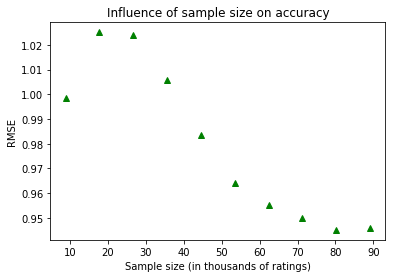

In [74]:
plt.plot(sample_sizes, scores, 'g^')
plt.xlabel('Sample size (in thousands of ratings)')
plt.ylabel('RMSE')
plt.title('Influence of sample size on accuracy')
plt.show()

We can understand from the graph than the more ratings we have the best the model is - at first! 
It is often the case for memory-based model. Since we have fixed the number of neighbors in this experiments,
the more ratings we have, the more ratings will be considered in the prediction, namely in the peer-set, hence giving a better result.
However, comes a time when adding to many peers to a user's neighborhood creates more noise than actual information. For instance if a user is very close in taste to 10 other users in the matrix and all the other users have opposite taste, a 11-nearest neighbor model will perform worse than a 10-nearest neighbor model for this user, as we had to add someone with poor compatibility in this user peer set.


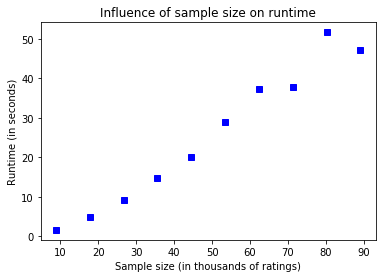

In [75]:
plt.plot(sample_sizes, times, 'bs')
plt.xlabel('Sample size (in thousands of ratings)')
plt.ylabel('Runtime (in seconds)')
plt.title('Influence of sample size on runtime')
plt.show()

As opposed to matrix factorization that was linear on the number of ratings we have, here with knn, we have a quadratic running time. 
The surprise implementation must be well optimized but we can still see that it is not linear. Indeed, it is a (n_users, n_items) matrix that we are using. 
The similarity matrix itself is a (n_users, n_users) matrix. Even if it is a symmetric matrix, it still is O(n_users x n_items).

<a id='13'></a>
### Evaluation of the models
___

#### Build the baseline

Let us load  and fit the baseline:

In [41]:
from lib import Baseline

In [42]:
baseline_model = Baseline.Baseline(unique_users = total_users, unique_items = total_items)
baseline_model.fit(X_train, y_train)

Baseline(response_vector=None, unique_items=879, unique_users=10000)

#### Evaluation

Now that we have tuned our algorithms with grid search and cross-validation, let us fit them to the testing data and compute our accuracy metrics - **RMSE** and **Kendall rank correlation coefficient** - to both algorithms and the baseline algorithm we implemented in `/lib/Baseline.py` that computes ratings by averaging over both users and items.

We will also look at the **coverage** of the algorithms, assuming we recommend the **top 10 movies** to each user:

Both evaluating metrics can be found in `/lib/metrics.py`

In [43]:
from lib import metrics

We predict values with the neighborhood model:

In [44]:
test = pd.DataFrame({'user' : X_test['user'], 'item' : X_test['item'], 'rating' : y_test})
test = Dataset.load_from_df(test, reader)
_, test = t_t_split(test, test_size = 1.)
prediction = nm.test(test)

In [45]:
nm_prediction = []
for pred in prediction:
    nm_prediction.append(pred.est)

We build dictionaries containing the evaluation metrics for each algorithm:

In [46]:
def round_float(float_nb):
    return float("{0:.3f}".format(float_nb))

In [47]:
import warnings

In [49]:
warnings.filterwarnings("ignore")
rmse = {'Baseline': -round_float(baseline_model.score(X_test, y_test.values)), 
        'MF': -round_float(mf_model.score(X_test, y_test.values)), 
        'NM': round_float(accuracy.rmse(prediction, verbose = False))}
rank_coeff = {'Baseline': round_float(metrics.kendall_rank_coeff(baseline_model, X_test, y_test, total_users)),
              'MF': round_float(metrics.kendall_rank_coeff(mf_model, X_test, y_test, total_users)), 
              'NM': round_float(metrics.kendall_rank_coeff_vectors(X_test, nm_prediction, y_test, total_users))}
coverage = {'Baseline': round_float(metrics.coverage(baseline_model, X_test, total_users, total_items)),
              'MF': round_float(metrics.coverage(mf_model, X_test, total_users, total_items)), 
              'NM': round_float(metrics.coverage_surprise(nm, X_test, y_test, total_users, total_items))}


In [49]:
utils.print_table(rmse, rank_coeff, coverage)

<html><body><table><tr><td><b>Algorithms</b></td><td><b>RMSE</b></td><td><b>Kendall rank</b></td><td><b>Coverage</b></td></tr><tr><td>Baseline</td><td>0.924</td><td>0.283</td><td>0.499</td></tr><tr><td>Matrix Factorization</td><td>0.862</td><td>0.288</td><td>0.501</td></tr><tr><td>User-based NM</td><td>0.936</td><td>0.187</td><td>0.237</td></tr></table></body></html>

**Analysis of Results**

***RMSE***

Matrix factorization performs significantly better than its two counterparts. User-based collaborative filtering has higher RMSE than the baseline. This greatly decreases our confidence in the ability of this model to bring something new to the table and relevant recommendations. 

***Rank coefficient***

Matrix factorization perforns slightly better than the baseline with regards to rank. User-based collaborative filtering performs rather poorly, as it ranks much less efficiently with regard to this metric than the baseline.

Absolute values are quite low and reflect the numerous ties that appeared in the data and reduced the kendall coefficient for many users before averaging.

***Coverage***

Matrix factorization and the baseline algorithms have similar coverage. They recommend approximately half of the movies - which is quite a large portion. What made this possible was the size of the data. We believe this wouldn't have been the case if we had applied the same algorithms to much larger datasets sampled from the full MovieLens data because of the **long-tail effect**. We haven't addressed this issue because it didn't matter as much on the data we had, but as the samples get bigger, the tail becomes more apparent. This results in popular movies being over-represented in recommendations, and can significantly reduce coverage.

***A comment on comparison between the baseline and matrix factorization***

It is important to remember that matrix factorization builds on the baseline: the baseline is nested in matrix factorization. Although matrix factorization learns the biases with gradient descent rather than directly computing it,  if the gd converges properly, it contains all the baseline information. 

It is not surprising that matrix factorization performs better than the baseline as the risk of overfitting was unlikely - with parameters that don't allow for too long a training (`n_epochs = 20`) or too complex a model (`n_factors = 10`). The factorization part of the prediction calibrate the biases to get closer to the actual ratings and add more accuracy, while also accounting for the user and item biases. The gain in accuracy is probably very small for each rating (high regularization parameter `lambd = 0.9`), big enough so that the RMSE can be significantly improved but small enough so that the ranking of movies by user is not fundamentally changed compared to the baseline, explaining the very close values for Kendall rank coefficient.

***Additional Comments - Possible explanations for the results***

Overall, user-based collaborative filtering performs rather poorly in comparison to the two other algorithms.
User-based neighborhood is a risky approach. The advantage of the item-based approach is that item similarity is more stable and can be efficiently pre-computed than in a business where there are a lot of incoming users.
Also, a recommender system based on nearest neighbor algorithms may be **unable to make any item recommendations for a particular user**. This stems from the fact that, for a user to be considered as a potential neighbor of another, they need to have at least one common rating. In a sparse context, we don't always have such a user for every user. As a result the accuracy of recommendations can be poor. 

Another factor contributing to poor accuracy is the choice of `k`. If `k` is too small, recommendations may be too grossly estimated, and give too much impact to the closest users. Conversely if `k` is too large, recommendations can become very noisy and be based on users that have poor similarity with one another. 
Even though we tuned this parameter, it is possible we skipped optimal values of `k` or that the data was such that for all values of k, a significant number of users did not rip benefits from being influenced by `k` other users.

Other advatanges of matrix factorization are thart it is widely used for its **scalability**, and its ability to handle sparse datasets, precisely by reducing the feature-space to a smaller, lower-dimensional latent feature-space.
Furthermore, since each user factor can be calculated independently of each other, this algorithm is embarrassingly **parallel** and well suited to multithreading. So, the possibility of always incorporating more users in the data makes it tempting to use matrix factorization to recommend movies to them.


<a id='14'></a>
### Our decision
___


We reject the user-based collaborative filtering model as it didn't not perform better than the baseline we implemented and we have no simple way to improve its accuracy that we believe sufficient to outperform the baseline.

As matrix factorization performs significantly better in terms of prediction accuracy, and a better in terms of ranking than the baseline we recommend deploying it. 

It has other attractive qualities that motivate our decision among which scalability with the possibility of parallelism. We expect coverage to decrease as the data grows and we recommend modifying the algorithm by tackling the long-tail effect before scaling.

